In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import liana as li

In [2]:
import muon as mu
import plotnine as p9
import mofax as mofa

/home/dbdimitrov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
INVERSE_FUN = lambda x: -np.log10(x)
groupby = 'cell_type_original' # NOTE: the same cell types but readable; TODO abbvreviate this garbage
sample_key = 'sample'
condition_key = 'patient_group'

In [4]:
resource = pd.read_csv(os.path.join('results', 'lr_pairs.csv'))
cell_pairs = pd.read_csv(os.path.join('results', 'cell_pairs.csv'))

In [5]:
resource = resource[resource['top1std']]

Run LIANA + MOFA

In [6]:
adata = sc.read_h5ad(os.path.join('results', 'kuppe_processed.h5ad'), backed='r')

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [7]:
mdata = li.multi.lrs_to_views(adata,
                              score_key='magnitude_rank',
                              inverse_fun=INVERSE_FUN,
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.3, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 15, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 20, # minimum number of interactions to keep a view
                              samples_per_view = 10, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0, # fill missing LR values across samples with this
                              verbose=True
                              )

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 162.04it/s]


In [8]:
outfile = os.path.join('results', 'models', 'mofatalk.h5ad')

In [9]:
model = mu.tl.mofa(mdata,
                   use_obs='union',
                   outfile=outfile,
                   seed=1337,
                   n_factors=10,
                   convergence_mode='slow',
                   scale_views=True,
                #    copy=True
                )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Loaded view='Cardiomyocyte&Cardiomyocyte' group='group1' with N=28 samples and D=230 features...
Loaded view='Lymphoid&Cardiomyocyte' group='group1' with N=28 samples and D=170 features...
Loaded view='Endothelial&Cardiomyocyte' group='group1' with N=28 samples and D=225 features...
Loaded view='Neuronal&Cardiomyocyte' group='group1' with N=28 

In [10]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=condition_key)
factor_scores.head()

,sample,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,patient_group
0,CK158,-2.666372,0.208225,-0.137331,-0.645521,0.013322,-0.060797,-0.064427,-0.071403,-0.024400,-0.029169,myogenic
1,CK159,-0.072433,0.738352,-0.304622,-0.184614,-0.247584,-0.071177,-0.089014,-0.083601,-0.094884,-0.049771,myogenic
2,CK160,0.257646,-0.383103,-0.360152,0.105625,0.701161,-0.104135,-0.046816,-0.103637,-0.010168,-0.039995,myogenic
3,CK162,0.575947,0.508319,-0.288252,-0.807658,-0.180584,-0.091087,-0.079098,-0.050479,1.695546,-0.052568,fibrotic
4,CK163,-1.234322,0.623385,-0.446480,-0.565488,-0.122620,-0.089944,-0.076606,-0.070652,-0.046439,-0.027675,myogenic


In [11]:
model = mofa.mofa_model(outfile)
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 28
Features: 6818
Groups: group1 (28)
Views: Adipocyte&Adipocyte (65), Adipocyte&Endothelial (96), Adipocyte&Fibroblast (116), Adipocyte&Vascular_SMCs (97), Cardiomyocyte&Cardiomyocyte (230), Cardiomyocyte&Endothelial (169), Cardiomyocyte&Lymphoid (147), Cardiomyocyte&Neuronal (183), Cardiomyocyte&Pericyte (172), Endothelial&Adipocyte (80), Endothelial&Cardiomyocyte (225), Endothelial&Endothelial (165), Endothelial&Fibroblast (196), Endothelial&Pericyte (169), Endothelial&Vascular_SMCs (226), Fibroblast&Adipocyte (101), Fibroblast&Endothelial (192), Fibroblast&Fibroblast (236), Fibroblast&Mast (225), Fibroblast&Myeloid (211), Fibroblast&Neuronal (214), Fibroblast&Vascular_SMCs (270), Lymphoid&Cardiomyocyte (170), Lymphoid&Lymphoid (107), Lymphoid&Myeloid (128), Mast&Fibroblast (151), Mast&Mast (136), Myeloid&Fibroblast (162), Myeloid&Lymphoid (127), Myeloid&Myeloid (164), Neuronal&Cardiomyocyte (226), Neuronal&Fibroblast (201), Neuronal&Neuro

Explore Results

In [12]:
factor_of_interest = "Factor1"

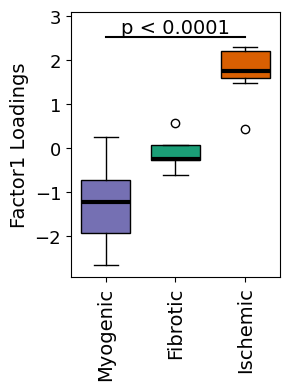

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway

# Assuming factor_scores is your DataFrame and condition_key is the column for conditions
factor_scores[condition_key] = factor_scores[condition_key].str.title().astype('category')
labels = ['Myogenic', 'Fibrotic', 'Ischemic']

# Set the color palette and style
colors = ['#7570b3', '#1b9e77', '#d95f02']

# Create a boxplot
plt.figure(figsize=(3, 4))
box_positions = np.arange(1, len(labels) + 1)

max_y = float('-inf')
min_y = float('inf')

for i, label in enumerate(labels):
    subset = factor_scores[factor_scores[condition_key] == label][factor_of_interest]
    plt.boxplot(subset, positions=[box_positions[i]], widths=0.7, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black', linewidth=3))
    max_y = max(max_y, max(subset))
    min_y = min(min_y, min(subset))

# Perform one-way ANOVA
groups = [factor_scores[factor_scores[condition_key] == group][factor_of_interest] for group in labels]
statistic, p_value = f_oneway(*groups)

pval = round(p_value, 3)

# Add comparison lines and p-value
y = max_y + 0.1 * max_y  # adjust 0.05 to change the height of the comparison lines
plt.plot([1, 3], [y, y], color='k')
plt.text(2, y, f'p < {pval+ 0.0001:.4f}', ha='center', va='bottom', size=14)

# extend y axis
plt.ylim(min_y*1.1, max_y + 0.35 * max_y)

# Set labels and title
plt.xlabel('')
plt.ylabel(f'{factor_of_interest} Loadings', fontsize=14)
plt.title('')
plt.xticks(box_positions, labels, fontsize=14, rotation=90) 
plt.yticks(fontsize=13)
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
variable_loadings =  li.ut.get_variable_loadings(mdata,
                                                 varm_key='LFs',
                                                 view_sep=':',
                                                 pair_sep="&",
                                                 variable_sep="^") # get loadings for factor 1
variable_loadings.head()

# here we will just assign the size of the dots, but this can be replace by any other statistic
variable_loadings['size'] = 4.5



In [15]:
variable_loadings.to_csv(os.path.join('results', 'kuppe_mofa_loadings.csv'))

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


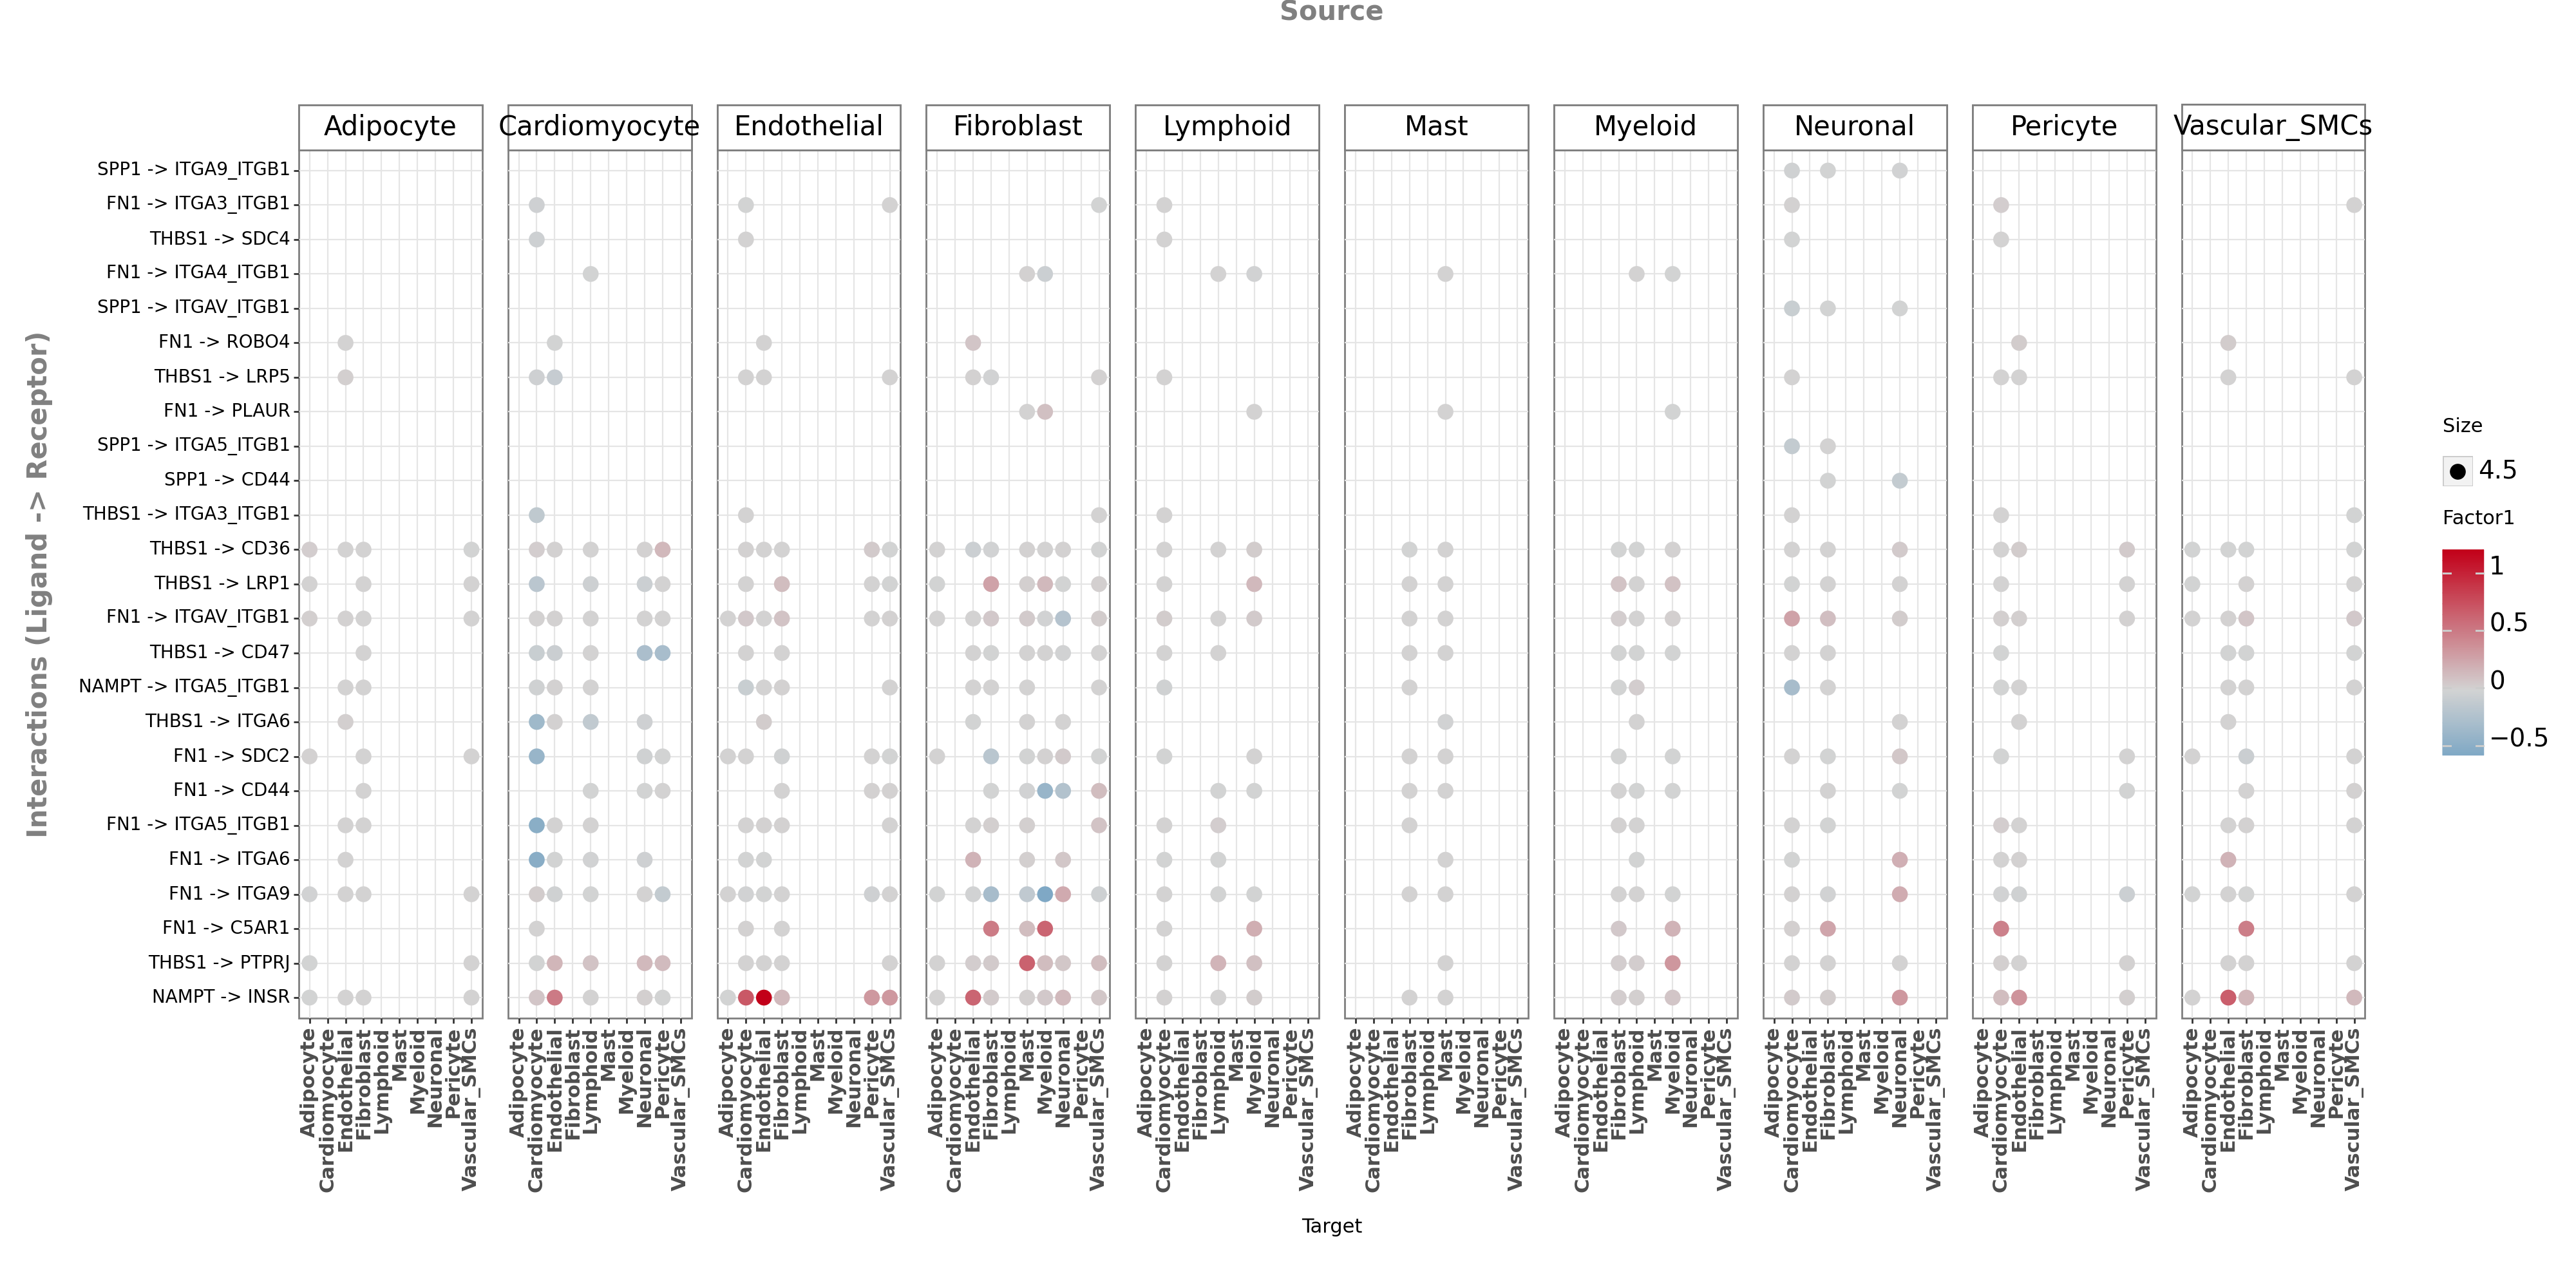

<Figure Size: (2000 x 1000)>

In [16]:
my_plot = li.pl.dotplot(liana_res = variable_loadings,
                        size='size',
                        colour=factor_of_interest,
                        orderby=factor_of_interest,
                        ligand_complex=["FN1", 'NAMPT', 'TNC', 'THBS1', 'SPP1'], 
                        top_n=25,
                        orderby_absolute=True,
                        orderby_ascending=False,
                        size_range=(0.1, 4),
                        figure_size=(20, 10)
                        )
# change colour, with mid as white
my_plot + p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0)

In [17]:
# import omnipath as op
# inter = op.interactions.import_intercell_network()

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


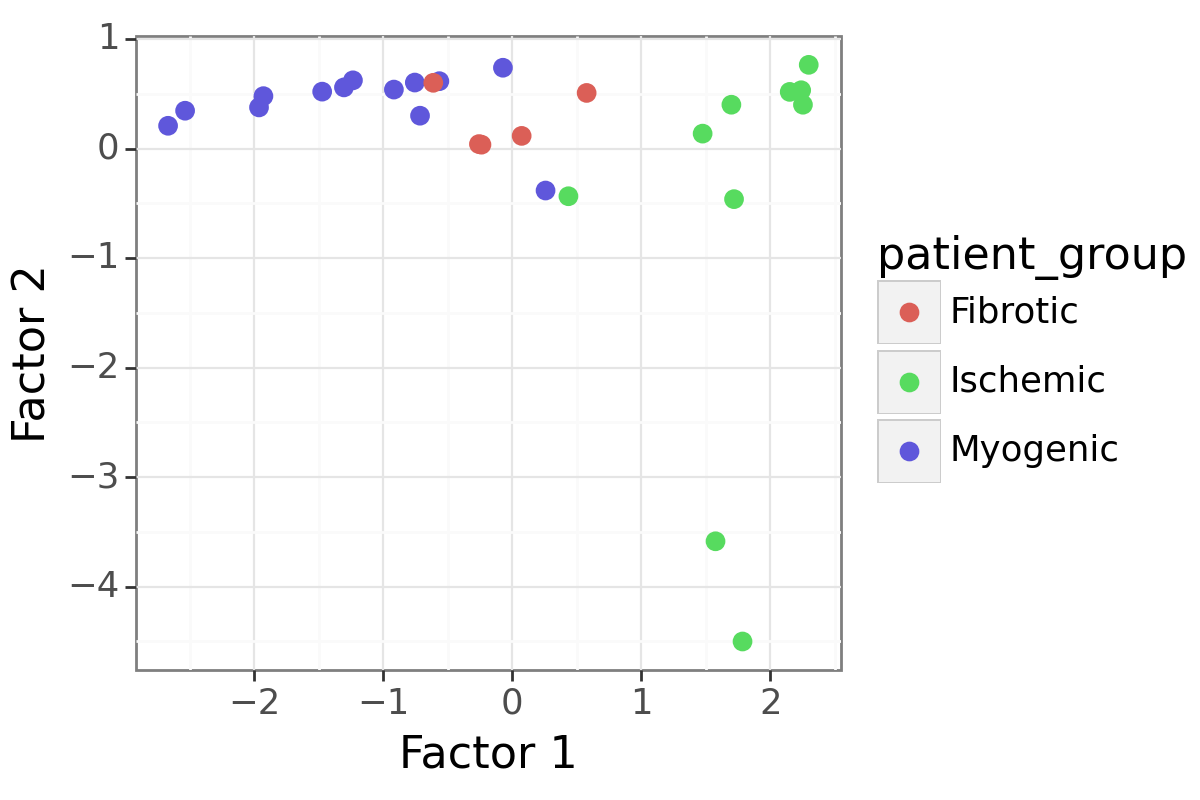

<Figure Size: (600 x 400)>

In [18]:
# dotplot of Factor1 (x) and Factor2 (y)
(
    p9.ggplot(factor_scores) +
    p9.aes(x='Factor1', y='Factor2', colour=condition_key) +
    p9.geom_point(size=3) +
    p9.theme_bw(base_size=16) +
    p9.theme(figure_size=(6, 4)) +
    p9.labs(x='Factor 1', y='Factor 2')
)

Factor 1 R2 per view

In [19]:
# get variance explained by view and factor
rsq = model.get_r2()
factor_rsq = rsq[rsq['Factor']==factor_of_interest]
# separate view column
factor_rsq[['source', 'target']] = factor_rsq['View'].str.split('&', 1, expand=True)

In [20]:
# Remove adipocyte as it does not explain much
factor_rsq = factor_rsq[~((factor_rsq['source'] == 'Adipocyte') | (factor_rsq['target'] == 'Adipocyte'))]

In [21]:
factor_rsq.sort_values("R2", ascending=False).head(15)

,Factor,View,Group,R2,source,target
8,Factor1,Fibroblast&Endothelial,group1,27.427939,Fibroblast,Endothelial
19,Factor1,Endothelial&Pericyte,group1,26.914396,Endothelial,Pericyte
7,Factor1,Myeloid&Lymphoid,group1,26.896214,Myeloid,Lymphoid
11,Factor1,Fibroblast&Myeloid,group1,26.836419,Fibroblast,Myeloid
23,Factor1,Pericyte&Pericyte,group1,26.587818,Pericyte,Pericyte
22,Factor1,Endothelial&Endothelial,group1,25.945818,Endothelial,Endothelial
6,Factor1,Cardiomyocyte&Endothelial,group1,23.961326,Cardiomyocyte,Endothelial
32,Factor1,Pericyte&Endothelial,group1,23.814819,Pericyte,Endothelial
17,Factor1,Myeloid&Myeloid,group1,23.626015,Myeloid,Myeloid
14,Factor1,Fibroblast&Neuronal,group1,23.309281,Fibroblast,Neuronal


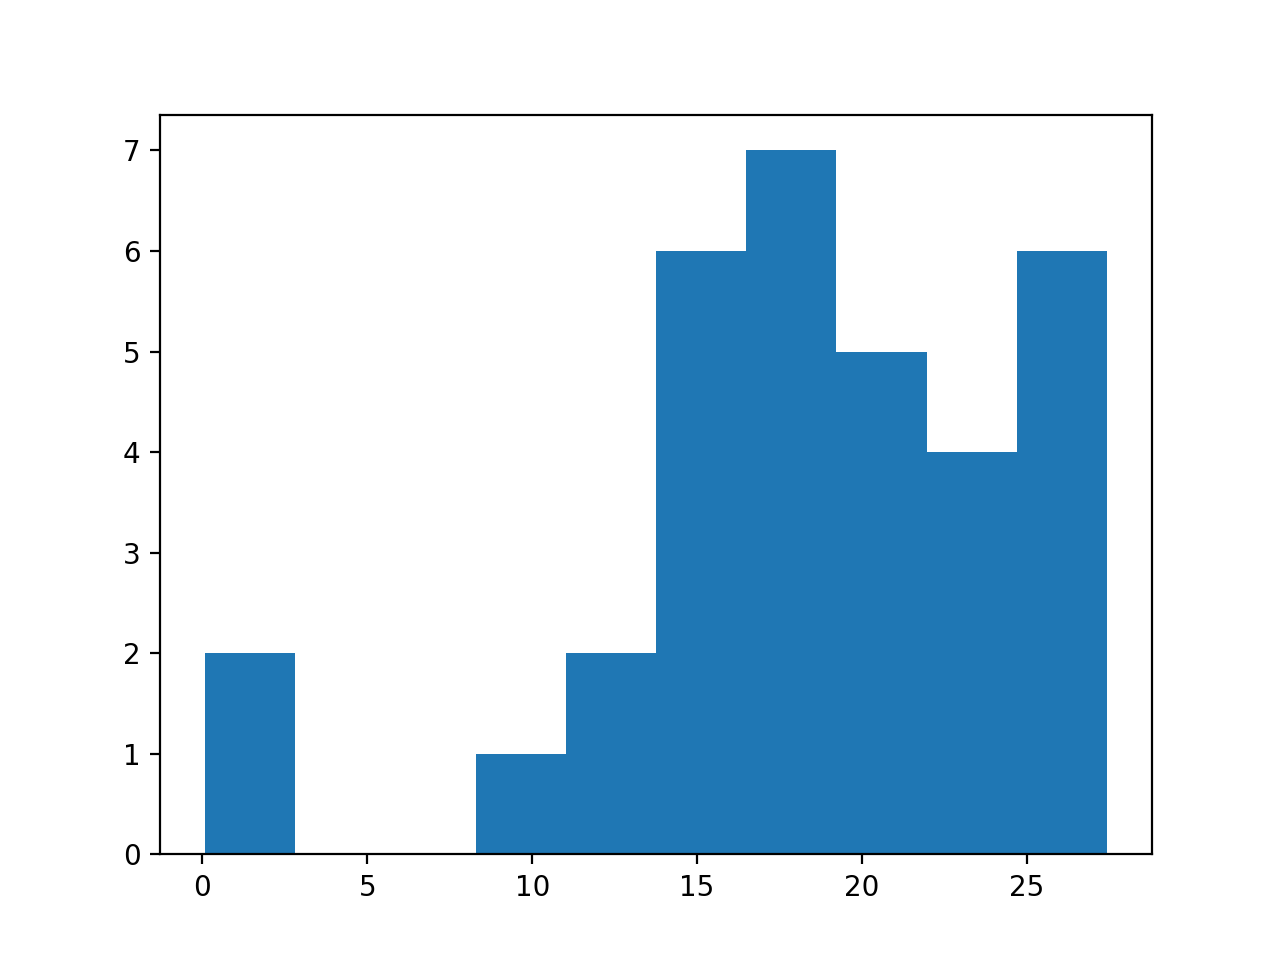

In [22]:
plt.hist(factor_rsq['R2']);

In [23]:
factor_rsq['source'] = factor_rsq['source'].astype('category')
factor_rsq['target'] = factor_rsq['target'].astype('category')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


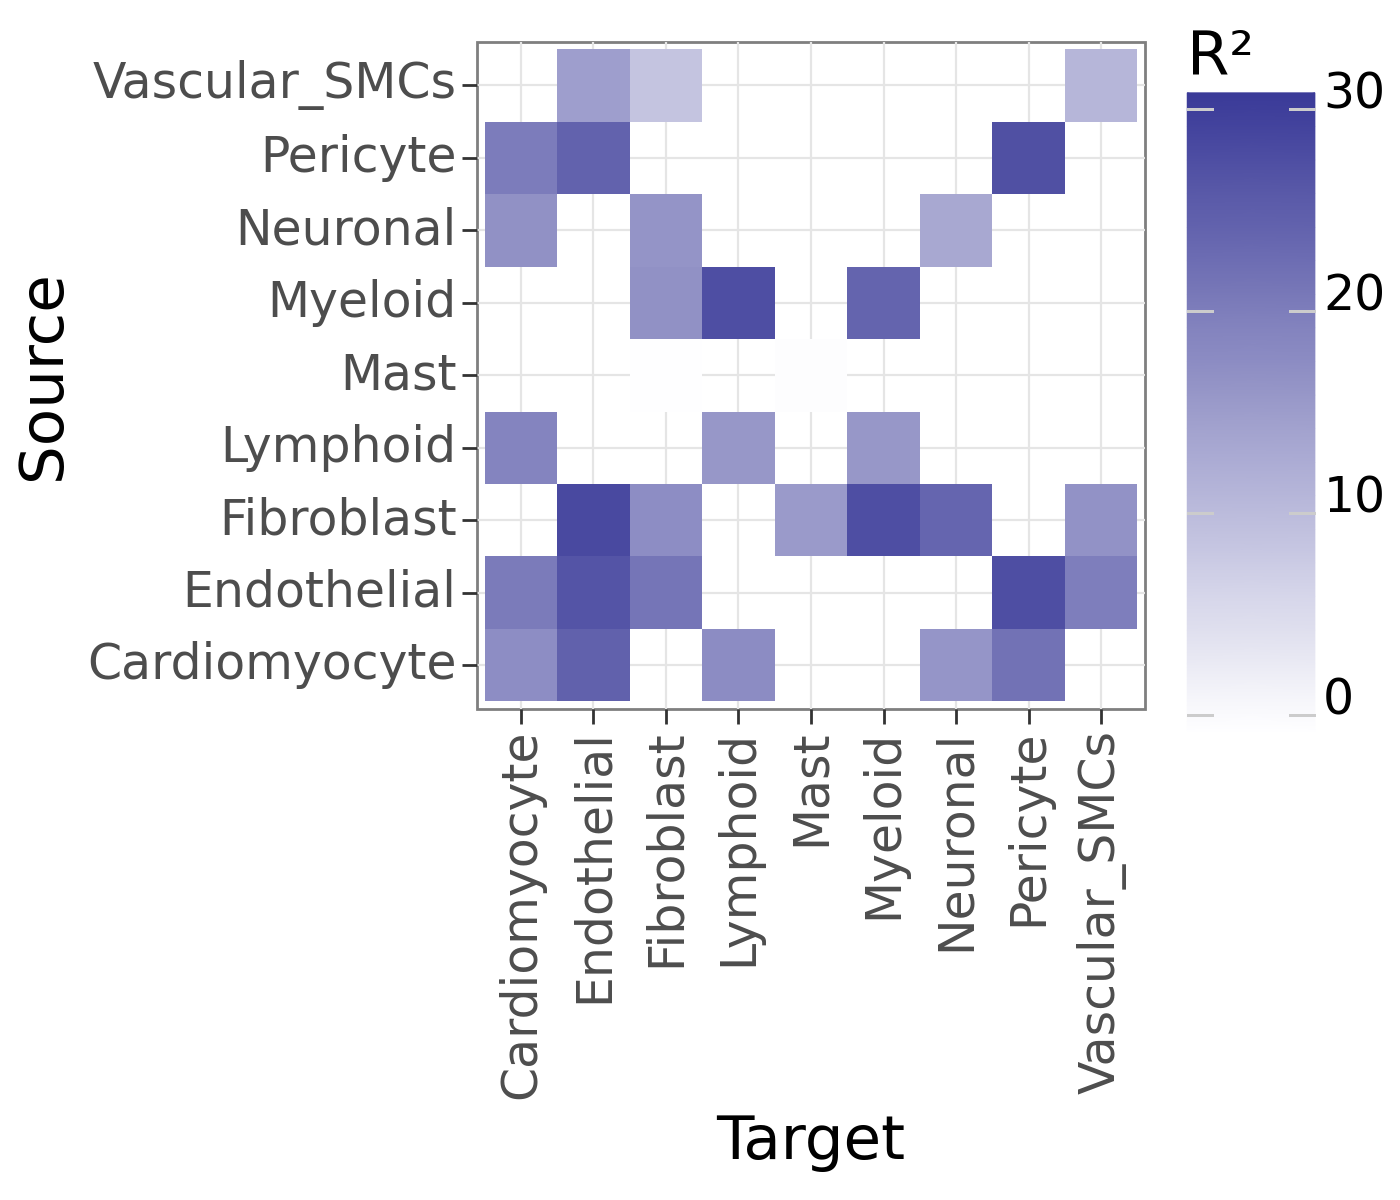

<Figure Size: (700 x 600)>

In [24]:
(p9.ggplot(factor_rsq.reset_index()) +
 p9.aes(x='target', y='source') +
 p9.geom_tile(p9.aes(fill='R2')) +
#  p9.scale_fill_gradient2(low='white', high='#c20019') +
# limits 
    p9.scale_fill_gradient2(limits=(0, 30)) +
 p9.theme_bw(base_size=22) +
 p9.labs(x='Target', y='Source', fill='R²') +
 p9.theme(axis_text_x=p9.element_text(rotation=90), figure_size=(7,6))
)

In [25]:
variable_loadings.sort_values(by="Factor1", ascending=False, key=abs).head()

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size
256,CALM1,RYR2,Lymphoid,Cardiomyocyte,-2.322011,0.031999,-0.000043,-0.012426,0.038067,0.113312,0.536409,-0.001623,0.070467,-0.022502,4.5
3124,CALM1,RYR2,Endothelial,Vascular_SMCs,-2.210037,0.014851,-0.064957,0.001833,-0.007645,0.215949,-0.036093,0.004170,-0.032987,-0.374228,4.5
4244,CALM1,RYR2,Endothelial,Endothelial,-2.130499,0.030715,-0.162850,0.004328,0.014155,0.129944,-0.067511,0.035033,-0.391927,-0.122780,4.5
3119,CALM1,CACNA1C,Endothelial,Vascular_SMCs,-2.070948,0.020283,0.008218,-0.011909,0.180657,0.014911,0.012785,0.001108,1.311637,-0.447014,4.5
1910,CALM1,RYR2,Pericyte,Cardiomyocyte,-2.058841,-0.002065,0.027452,0.031494,0.091225,0.192298,-0.145476,0.000840,-0.184058,0.509759,4.5


In [26]:
ct_int = variable_loadings[(variable_loadings['source']=='Fibroblast') & (variable_loadings['target']=='Myeloid')]

In [27]:
# rank by absolute values of Factor 1
ct_int['rank'] = ct_int['Factor1'].rank(ascending=False)

In [28]:
ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(5)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank
2229,LAMA2,CD44,Fibroblast,Myeloid,-1.461103,0.004320,0.247585,0.000796,0.190613,-0.096138,0.287729,0.240749,0.019294,-0.000088,4.5,211.0
2186,DCN,TLR2,Fibroblast,Myeloid,-1.313346,0.014393,0.108009,-0.003264,-0.185910,-0.207857,-0.004352,-0.081696,-0.036532,-0.000841,4.5,210.0
2230,LAMA2,ITGA9_ITGB1,Fibroblast,Myeloid,-1.249245,0.019041,0.235486,0.108946,0.049366,0.292601,-0.017833,-0.064987,0.013944,0.000389,4.5,209.0
2145,CALM1,RYR2,Fibroblast,Myeloid,-1.126504,0.001754,-0.317813,0.000501,0.025681,0.341359,-0.015785,-0.137053,-0.066805,-0.000900,4.5,208.0
2237,LAMC1,CD44,Fibroblast,Myeloid,-1.041219,0.001199,-0.182218,-0.001192,0.108450,-0.174115,-0.002402,0.150301,0.035999,0.000501,4.5,207.0


In [29]:

ct_int['name'] = ct_int['ligand_complex'] + ' -> ' + ct_int['receptor_complex']
# # keep name for only the top 5 by absolute values of Factor 1
# ct_names = ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(1)['name'].tolist()
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_names else '')
# keep top 1 according to rank
ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int.sort_values(by='rank', ascending=True).head(1)['name'].tolist() else '')
## keep name where ligand_complex=="LAMA2" and receptor_complex=="ITGA6_ITGB1" (top 3)
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['ligand_complex']=="LAMA2"]['name'].tolist() else '')
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['receptor_complex']=="ITGA6_ITGB1"]['name'].tolist() else '')

In [30]:
ct_int.sort_values("Factor1").tail(10)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
2251,NAMPT,INSR,Fibroblast,Myeloid,0.055024,-0.006285,0.844644,0.005467,-0.005446,0.637755,0.229516,0.055796,-0.048279,0.000924,4.5,10.0,
2117,ADAM12,ITGB1,Fibroblast,Myeloid,0.079045,-0.005581,-0.015796,0.000059,0.266927,0.767016,-0.000086,-0.001061,0.453079,0.008917,4.5,9.0,
2268,SERPINE1,PLAUR,Fibroblast,Myeloid,0.101623,-0.719793,0.099662,-0.008004,-0.023557,-0.080338,7.777270,0.014262,-0.013510,-0.000419,4.5,8.0,
2203,FN1,PLAUR,Fibroblast,Myeloid,0.102724,-2.193816,-0.094004,-0.033895,0.022113,-0.203073,3.718369,0.105767,-0.000311,-0.000568,4.5,7.0,
2165,COL1A2,CD36,Fibroblast,Myeloid,0.109061,-1.873046,-0.040620,0.001460,-0.157248,0.294553,0.052703,-0.050358,-0.014459,-0.000542,4.5,6.0,
2294,THBS1,PTPRJ,Fibroblast,Myeloid,0.119637,-0.000089,0.012424,0.000737,1.416968,0.137048,0.081126,0.619155,-0.032388,0.000024,4.5,5.0,
2293,THBS1,LRP1,Fibroblast,Myeloid,0.135961,-0.022960,-0.005389,-0.000260,1.031020,0.734887,1.519049,2.176366,-0.059827,-0.000655,4.5,4.0,
2162,COL1A1,CD36,Fibroblast,Myeloid,0.493260,-1.393254,-0.106989,0.003389,-0.037574,0.642086,-0.012579,0.017678,-0.049459,0.000202,4.5,3.0,
2267,SERPINE1,LRP1,Fibroblast,Myeloid,0.574261,-0.066762,0.115603,-0.005604,-0.017806,0.073720,6.176013,-0.028685,-0.033940,-0.000204,4.5,2.0,
2198,FN1,C5AR1,Fibroblast,Myeloid,0.598381,-1.141478,-0.011952,-0.006966,-0.009489,-0.148451,3.059613,0.036063,-0.051323,0.000195,4.5,1.0,FN1 -> C5AR1


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


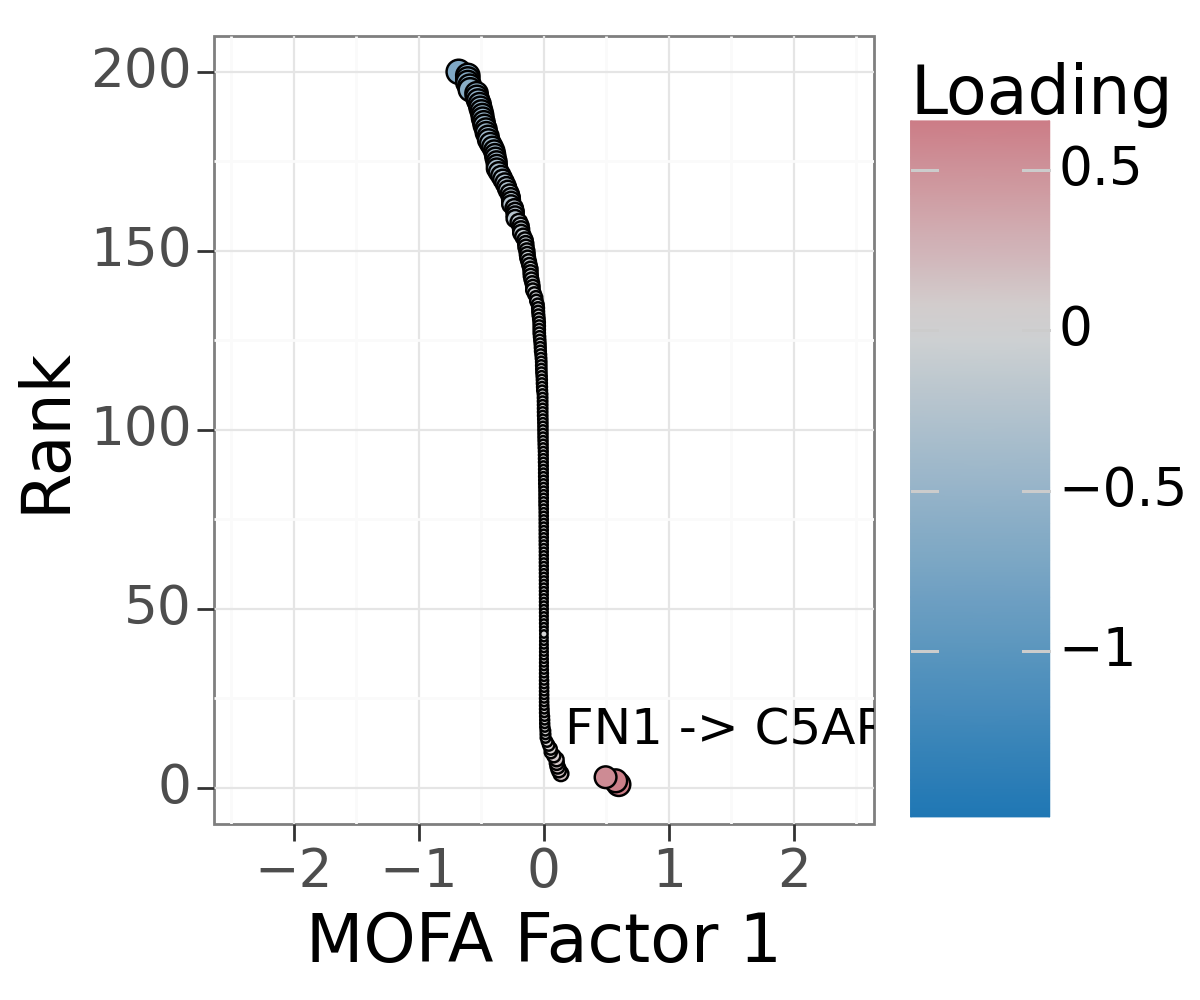

<Figure Size: (600 x 500)>

In [31]:
ct_int['size'] = ct_int['Factor1'].abs()
(
    p9.ggplot(ct_int) +
    p9.aes(x='Factor1', y='rank', fill='Factor1', size='size') +
    p9.geom_point() +
    p9.geom_text(p9.aes(label='name'), size=18, nudge_x=1, nudge_y=15) +
    p9.theme_bw(base_size=24) +
    p9.theme(figure_size=(6, 5)) +
    p9.scale_x_continuous(limits=(-2.4, 2.4)) +
    # scale rank to 0-200
    p9.scale_y_continuous(limits=(0, 200)) +
    p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0) +
    p9.labs(x='MOFA Factor 1', y='Rank', fill='Loading') +
    # hide size
    p9.guides(size=False)
)

In [32]:
ct_int.sort_values("Factor1", key=abs, ascending=False)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
2229,LAMA2,CD44,Fibroblast,Myeloid,-1.461103,0.004320,0.247585,7.961117e-04,0.190613,-0.096138,0.287729,0.240749,0.019294,-0.000088,1.461103,211.0,
2186,DCN,TLR2,Fibroblast,Myeloid,-1.313346,0.014393,0.108009,-3.264253e-03,-0.185910,-0.207857,-0.004352,-0.081696,-0.036532,-0.000841,1.313346,210.0,
2230,LAMA2,ITGA9_ITGB1,Fibroblast,Myeloid,-1.249245,0.019041,0.235486,1.089457e-01,0.049366,0.292601,-0.017833,-0.064987,0.013944,0.000389,1.249245,209.0,
2145,CALM1,RYR2,Fibroblast,Myeloid,-1.126504,0.001754,-0.317813,5.007242e-04,0.025681,0.341359,-0.015785,-0.137053,-0.066805,-0.000900,1.126504,208.0,
2237,LAMC1,CD44,Fibroblast,Myeloid,-1.041219,0.001199,-0.182218,-1.192252e-03,0.108450,-0.174115,-0.002402,0.150301,0.035999,0.000501,1.041219,207.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,VWF,LRP1,Fibroblast,Myeloid,-0.000072,-0.000537,-0.002705,-3.623605e-04,-0.002287,0.921374,0.003965,-0.017618,-0.014546,-0.001325,0.000072,45.0,
2321,VWF,ITGB1,Fibroblast,Myeloid,-0.000063,0.000038,-0.021016,-1.141061e-07,0.000006,0.454025,0.078054,0.000009,0.000200,-0.000276,0.000063,44.0,
2320,VWF,ITGA9,Fibroblast,Myeloid,0.000037,0.000218,0.109251,5.104992e-04,-0.000453,0.008091,0.012677,-0.018150,-0.010055,0.009061,0.000037,41.0,
2184,CXCL12,ITGAV,Fibroblast,Myeloid,0.000021,-0.012433,-0.007538,8.430688e-05,0.000690,0.002097,-0.001023,-0.005562,0.227010,0.006764,0.000021,42.0,


In [33]:
model.get_variance_explained().sort_values("R2").tail()

,Factor,View,Group,R2
11,Factor1,Fibroblast&Myeloid,group1,26.836419
7,Factor1,Myeloid&Lymphoid,group1,26.896214
19,Factor1,Endothelial&Pericyte,group1,26.914396
8,Factor1,Fibroblast&Endothelial,group1,27.427939
114,Factor3,Adipocyte&Vascular_SMCs,group1,27.808752
